---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 3**: Improving Lexical Search

### 📅 **Due Date**: Day of Lecture 4, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

You'll apply what we covered in Lecture 3 (Lexical Search & BM25) to a real e-commerce search problem using the **WANDS dataset** 
- WANDS stands for Wayfair Annotated Dataset. It's a dataset of furniture products and search queries, along with human relevance judgments.

You will:
1. **Build a search engine** from scratch using BM25.
2. **Learn how to evaluate search results** using NDCG — a metric for measuring search quality
3. **Attempt to improve your search engine** by adding multiple fields
4. **Use LLMs to improve your search engine** by adding simple query understanding

Yes, *you* will do all these things. Let's go!

---

## Task 1: Environment Setup

First, let's set up your environment and verify everything works.

### 1a. Install dependencies and verify imports

Run `uv add pystemmer` in your terminal to add the Snowball stemmer. Then run the cell below to verify all imports work.

In [1]:
# Task 1a: Verify imports work
import pandas as pd
import numpy as np
from collections import Counter
import string
from pathlib import Path
# a stemmer from `pystemmer` for better tokenization
import Stemmer 
# llm packages
import litellm
from pydantic import BaseModel, Field
from typing import Optional
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Pandas display settings
# pd.set_option('display.max_colwidth', 100)

# Ignore pydantic warnings for litellm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pydantic")

print("All imports successful!")

All imports successful!


### 1b. Verify API keys

Test that your API keys work by making a simple call.

In [3]:
import litellm
litellm.set_verbose = True


In [5]:
import os
from dotenv import load_dotenv
load_dotenv()

if os.getenv("GOOGLE_API_KEY") and not os.getenv("GEMINI_API_KEY"):
    os.environ["GEMINI_API_KEY"] = os.getenv("GOOGLE_API_KEY")

print("GEMINI_API_KEY loaded:", bool(os.getenv("GEMINI_API_KEY")))


GEMINI_API_KEY loaded: True


In [6]:
import os
os.environ["LITELLM_LOG"] = "DEBUG"


In [7]:
import os
import litellm

response = litellm.completion(
    model="gemini/gemini-2.5-flash",
    api_key=os.getenv("GEMINI_API_KEY"),   # force the key explicitly
    messages=[{"role": "user", "content": "Reply with exactly: API working!"}],
    max_tokens=50,
    temperature=0,
)

print("RAW:", response)
print("TEXT:", response.choices[0].message.content)


17:01:00 - LiteLLM:WARNING: utils.py:758 - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.


SYNC kwargs[caching]: False; litellm.cache: None; kwargs.get('cache')['no-cache']: False
Final returned optional params: {'temperature': 0, 'max_output_tokens': 50}
RAW: ModelResponse(id='nHt-ad3NL7eN_PUPp_LT0Qg', created=1769896860, model='gemini-2.5-flash', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='stop', index=0, message=Message(content='API working!', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None))], usage=Usage(completion_tokens=38, prompt_tokens=8, total_tokens=46, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=35, rejected_prediction_tokens=None, text_tokens=3, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=8, image_tokens=None), cache_read_input_tokens=None), vertex_ai_grounding_metadata=[], vertex_ai_url_context_metada

In [8]:
# Task 1b: Verify API keys
import litellm
from dotenv import load_dotenv
load_dotenv()

response = litellm.completion(
    model="gemini/gemini-2.5-flash",
    messages=[{"role": "user", "content": "Say 'API working!' and nothing else."}],
    max_tokens=20
)
print(response.choices[0].message.content)

17:02:27 - LiteLLM:WARNING: utils.py:758 - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.


SYNC kwargs[caching]: False; litellm.cache: None; kwargs.get('cache')['no-cache']: False
Final returned optional params: {'max_output_tokens': 20}
API


---

## Task 2: Load and Explore the WANDS Dataset

The **WANDS dataset** (Wayfair Annotated Dataset) contains:
- 43K furniture products from Wayfair
- 480 real search queries
- 233K human relevance judgments (query-product pairs)

This is a real-world search benchmark used to evaluate e-commerce search systems!

**Data Source**: [WANDS on GitHub](https://github.com/wayfair/WANDS)

The data files are pre-downloaded in the `data/` directory:
- `wayfair-products.csv` - Product catalog
- `wayfair-queries.csv` - Search queries
- `wayfair-labels.csv` - Relevance judgments

### Data Loading Functions (provided)

Run the cell below to define the loading functions.

In [15]:
# Data loading functions (provided)
# Note: Data from WANDS (Wayfair Annotated Dataset)
# Source: https://github.com/wayfair/WANDS

from pathlib import Path

def load_wands_products(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS products from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-products.csv
        
    Returns:
        DataFrame with product information including product_id, product_name,
        product_class, category_hierarchy, product_description, etc.
    """
    filepath = Path(data_dir) / "wayfair-products.csv"
    products = pd.read_csv(filepath, sep='\t')
    products = products.rename(columns={'category hierarchy': 'category_hierarchy'})
    return products

def load_wands_queries(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS queries from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-queries.csv
        
    Returns:
        DataFrame with query_id and query columns
    """
    filepath = Path(data_dir) / "wayfair-queries.csv"
    queries = pd.read_csv(filepath, sep='\t')
    return queries

def load_wands_labels(data_dir: str = "../data") -> pd.DataFrame:
    """
    Load WANDS relevance labels from local file.
    
    Args:
        data_dir: Path to the data directory containing wayfair-labels.csv
        
    Returns:
        DataFrame with query_id, product_id, label (Exact/Partial/Irrelevant),
        and grade (2/1/0) columns
    """
    filepath = Path(data_dir) / "wayfair-labels.csv"
    labels = pd.read_csv(filepath, sep='\t')
    grade_map = {'Exact': 2, 'Partial': 1, 'Irrelevant': 0}
    labels['grade'] = labels['label'].map(grade_map)
    return labels

print("Loading functions defined!")

Loading functions defined!


### 2a. Load the data

Use the provided functions to load all three datasets. Print the number of rows in each.

In [14]:
import os
print(os.getcwd())


/Users/yeshwanth/Desktop/ai-engineering-fordham


In [16]:
# Task 2a: Load the data

# Task 2a: Load the data

products = load_wands_products(data_dir="data")
queries = load_wands_queries(data_dir="data")
labels = load_wands_labels(data_dir="data")

print("Products rows:", len(products))
print("Queries rows:", len(queries))
print("Labels rows:", len(labels))


Products rows: 42994
Queries rows: 480
Labels rows: 233448


### 2b. Explore products

List the available columns, and display a few sample products. 

Which columns might be useful for search?

In [19]:
# Task 2b: Explore products

print("Product columns:")
print(products.columns)

print("\nSample products:")
display(products.head())


Product columns:
Index(['product_id', 'product_name', 'product_class', 'category_hierarchy',
       'product_description', 'product_features', 'rating_count',
       'average_rating', 'review_count'],
      dtype='object')

Sample products:


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboa...,"good , deep sleep can be quite difficult to ha...",overallwidth-sidetoside:64.7|dsprimaryproducts...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,"create delicious slow-cooked meals , from tend...",capacityquarts:7|producttype : slow cooker|pro...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances ...,prepare home-cooked meals on any schedule with...,features : keep warm setting|capacityquarts:6....,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to c...,overallwidth-sidetoside:3.5|warrantylength : l...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with roun...,Door Knobs,Home Improvement / Doors & Door Hardware / Doo...,the hardware has a rich heritage of delivering...,compatibledoorthickness:1.375 '' |countryofori...,70.0,5.0,42.0


The most useful columns for search are product_name, product_description, and category_hierarchy, because they contain the main natural-language information describing each product. These fields help match user queries to relevant items through keyword or semantic similarity.

The product_class column is also useful because it provides structured category information that can improve filtering and ranking. Additionally, product_features may help advanced search systems extract structured attributes (e.g., size, capacity, materials). Ratings columns such as average_rating and review_count are less useful for matching relevance but can help with ranking results.

In [ ]:
# YOUR CODE HERE


### 2c. Understand relevance judgments

The `labels` dataset contains human judgments of relevance. In particular, for each query-product pair, it contains:
| Label        | Grade | Description                                 |
|--------------|-------|---------------------------------------------|
| Exact        |   2   | This product is exactly what the user wants |
| Partial      |   1   | This product is somewhat relevant           |
| Irrelevant   |   0   | This product doesn't match the query        |

First, let's look at the distribution of grades.

In [20]:
# Task 2c: Understand judgments

# Task 2c: Distribution of relevance grades

print("Grade distribution:")
print(labels["grade"].value_counts().sort_index())

print("\nLabel distribution:")
print(labels["label"].value_counts())


Grade distribution:
grade
0     61201
1    146633
2     25614
Name: count, dtype: int64

Label distribution:
label
Partial       146633
Irrelevant     61201
Exact          25614
Name: count, dtype: int64


The dataset is imbalanced toward partially relevant results. Most query-product pairs are labeled Partial (grade 1) with 146,633 examples. This is followed by Irrelevant (grade 0) with 61,201 examples, and Exact matches (grade 2) with 25,614 examples.

This distribution suggests that most products are somewhat relevant to a query, but fewer are exact matches. In a real search system, this imbalance is important because ranking models must learn to distinguish highly relevant results from many moderately relevant ones. It also means evaluation metrics should account for graded relevance rather than treating search as a simple binary problem.

---
## Task 3: Build and Run BM25 Search

Now let's build a BM25 search engine! We'll use the same concepts from Lecture 3.

### Provided Functions

We're giving you these functions to work with. Run the next cell to define them, then look at the examples.

| Function | What it does |
|----------|--------------|
| `snowball_tokenize(text)` | Tokenizes text, removes punctuation, stems words |
| `build_index(docs, tokenizer)` | Builds an inverted index from a list of documents |
| `get_tf(term, doc_id, index)` | Gets term frequency for a term in a document |
| `get_df(term, index)` | Gets document frequency for a term (how many docs contain the term) |
| `bm25_idf(df, num_docs)` | Calculates the IDF component of BM25 |
| `bm25_tf(tf, doc_len, avg_doc_len)` | Calculates the TF normalization for BM25 |
| `score_bm25(query, index, ...)` | Scores all documents for a query using BM25 |
| `search_products(query, ...)` | Searches and returns top-k results |

In [17]:
# Provided functions - run this cell to define them

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """
    Tokenize text with Snowball stemming.
    
    Args:
        text: The text to tokenize
        
    Returns:
        List of stemmed tokens
    """
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """
    Build an inverted index from a list of documents.
    
    Args:
        docs: List of document strings to index
        tokenizer: Function that takes text and returns list of tokens
        
    Returns:
        index: dict mapping term -> {doc_id: term_count}
        doc_lengths: list of document lengths (in tokens)
    """
    index = {}
    doc_lengths = []
    
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    
    return index, doc_lengths

def get_tf(term: str, doc_id: int, index: dict) -> int:
    """
    Get term frequency for a term in a document.
    
    Args:
        term: The term to look up
        doc_id: The document ID
        index: The inverted index
        
    Returns:
        Term frequency (count), or 0 if not found
    """
    if term in index and doc_id in index[term]:
        return index[term][doc_id]
    return 0

def get_df(term: str, index: dict) -> int:
    """
    Get document frequency for a term.
    
    Args:
        term: The term to look up
        index: The inverted index
        
    Returns:
        Number of documents containing the term
    """
    if term in index:
        return len(index[term])
    return 0

def bm25_idf(df: int, num_docs: int) -> float:
    """
    BM25 IDF formula.
    
    Args:
        df: Document frequency
        num_docs: Total number of documents
        
    Returns:
        IDF score
    """
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """
    BM25 TF normalization.
    
    Args:
        tf: Term frequency
        doc_len: Document length in tokens
        avg_doc_len: Average document length
        k1: Saturation parameter (default 1.2)
        b: Length normalization (default 0.75)
        
    Returns:
        Normalized TF score
    """
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """
    Score all documents using BM25.
    
    Args:
        query: The search query
        index: Inverted index
        num_docs: Total number of documents
        doc_lengths: List of document lengths
        tokenizer: Tokenization function
        
    Returns:
        Array of scores for each document
    """
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue
        
        idf = bm25_idf(df, num_docs)
        
        if token in index:
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    """
    Search products and return top-k results.
    
    Args:
        query: The search query
        products_df: DataFrame of products
        index: Inverted index
        doc_lengths: Document lengths
        tokenizer: Tokenization function
        k: Number of results to return
        
    Returns:
        DataFrame with top-k products and scores
    """
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("All functions defined!")

All functions defined!


In [18]:
# Examples of each function

# 1. snowball_tokenize - tokenizes and stems text
print("1. snowball_tokenize('Running shoes are amazing!')")
print(f"   -> {snowball_tokenize('Running shoes are amazing!')}")
print("   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'")

# 2. build_index - builds inverted index (we'll use a tiny example)
tiny_docs = ["red shoe", "blue shoe", "red hat"]
tiny_index, tiny_lengths = build_index(tiny_docs, snowball_tokenize)
print("\n2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)")
print(f"   Index: {tiny_index}")
print(f"   Lengths: {tiny_lengths}")

# 3. get_tf - get term frequency
print("\n3. get_tf('red', doc_id=0, tiny_index)")
print(f"   -> {get_tf('red', 0, tiny_index)}  (doc 0 = 'red shoe' has 1 'red')")

# 4. get_df - get document frequency  
print("\n4. get_df('red', tiny_index)")
print(f"   -> {get_df('red', tiny_index)}  ('red' appears in 2 documents)")

# 5. bm25_idf - calculate IDF (rare terms get higher scores)
print("\n5. bm25_idf(df=100, num_docs=10000)")
print(f"   -> {bm25_idf(100, 10000):.4f}  (term in 100 of 10000 docs)")

# 6. bm25_tf - normalize term frequency by document length
print("\n6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)")
print(f"   -> {bm25_tf(3, 50, 100):.4f}  (short doc gets boosted)")

# 7-8. score_bm25 and search_products - we'll use these next!
print("\nWe'll use score_bm25() and search_products() in Task 3a!")

1. snowball_tokenize('Running shoes are amazing!')
   -> ['run', 'shoe', 'are', 'amaz']
   Notice: 'Running' -> 'run', 'shoes' -> 'shoe', 'amazing' -> 'amaz'

2. build_index(['red shoe', 'blue shoe', 'red hat'], tokenizer)
   Index: {'red': {0: 1, 2: 1}, 'shoe': {0: 1, 1: 1}, 'blue': {1: 1}, 'hat': {2: 1}}
   Lengths: [2, 2, 2]

3. get_tf('red', doc_id=0, tiny_index)
   -> 1  (doc 0 = 'red shoe' has 1 'red')

4. get_df('red', tiny_index)
   -> 2  ('red' appears in 2 documents)

5. bm25_idf(df=100, num_docs=10000)
   -> 4.6003  (term in 100 of 10000 docs)

6. bm25_tf(tf=3, doc_len=50, avg_doc_len=100)
   -> 1.7600  (short doc gets boosted)

We'll use score_bm25() and search_products() in Task 3a!


### 3a. Create BM25 index for product_name

Build an inverted index for the `product_name` field and run a sample search for a product.

In [19]:
# Task 3a: Create BM25 index for product_name

# 1) Build corpus (docs) from product_name
docs = products["product_name"].fillna("").astype(str).tolist()

# 2) Build inverted index + doc lengths
index, doc_lengths = build_index(docs, snowball_tokenize)

print("Indexed documents:", len(docs))
print("Unique terms in index:", len(index))
print("Average doc length:", np.mean(doc_lengths))

# 3) Run a sample search
query = "platform bed"
results = search_products(query, products, index, doc_lengths, snowball_tokenize, k=10)

display(results[["rank", "product_id", "product_name", "product_class", "score"]])



Indexed documents: 42994
Unique terms in index: 25570
Average doc length: 6.534493185095594


,rank,product_id,product_name,product_class,score
26156,1,26156,platform bed,Teen Beds|Beds,9.582685
24205,2,24205,platform bed,NaN,9.582685
42881,3,42881,vong platform bed,Beds,8.812293
2691,4,2691,lyster platform bed,Teen Beds|Beds,8.812293
42451,5,42451,arcadio platform bed,NaN,8.812293
42733,6,42733,jarvis platform bed,Beds,8.812293
42727,7,42727,ursula platform bed,Beds,8.812293
42904,8,42904,gina platform bed,Beds,8.812293
42235,9,42235,greylock platform bed,Beds,8.812293
42164,10,42164,joker platform bed,Beds,8.812293


### 3b. Add product_description to search

Create a second index for `product_description` and combine scores from both fields.

**Hint**: You can combine the two scores by adding them together. This is like multi-field search from Lecture 3.

In [24]:
# Task 3b: Add product_description to search

# Task 3b: Add product_description to search (multi-field BM25)

# 1) Build corpus + index for product_description
desc_docs = products["product_description"].fillna("").astype(str).tolist()
desc_index, desc_doc_lengths = build_index(desc_docs, snowball_tokenize)

print("Description docs indexed:", len(desc_docs))
print("Unique terms in description index:", len(desc_index))
print("Avg description length:", np.mean(desc_doc_lengths))

# 2) Combine BM25 scores from name + description
def search_products_multifield(query: str, k: int = 10) -> pd.DataFrame:
    name_scores = score_bm25(query, index, len(products), doc_lengths, snowball_tokenize)
    desc_scores = score_bm25(query, desc_index, len(products), desc_doc_lengths, snowball_tokenize)

    combined_scores = name_scores + desc_scores  # simple linear combination

    top_k_idx = np.argsort(-combined_scores)[:k]
    results = products.iloc[top_k_idx].copy()
    results["score"] = combined_scores[top_k_idx]
    results["rank"] = range(1, k + 1)
    return results

# 3) Run a sample search
query = "platform bed"
results_multi = search_products_multifield(query, k=10)
display(results_multi[["rank", "product_id", "product_name", "product_class", "score"]])


Description docs indexed: 42994
Unique terms in description index: 20386
Avg description length: 65.40210261897009


,rank,product_id,product_name,product_class,score
25854,1,25854,brooking upholstered platform bed,Beds,19.271547
1055,2,1055,mulcahey storage platform bed,Beds,18.878980
20347,3,20347,dildy platform bed frame,NaN,18.572496
17289,4,17289,masonville queen platform bed,Beds,18.551161
16880,5,16880,gheorghita upholstered platform bed,Beds,18.491065
19803,6,19803,quinn upholstered platform bed,Beds,18.431013
11106,7,11106,fresca platform bed,NaN,18.384388
32364,8,32364,toth platform bed,Kids Beds,18.292882
18319,9,18319,knobel luxe upholstered platform bed,Beds,18.259955
34655,10,34655,kaylee platform bed,Beds,18.117456


---

## Task 4: Measuring Search Quality

We built a little search engine. How do we know if it's any good?

Consider two search results for "coffee table":

| Ranking A | Ranking B |
|-----------|-----------|
| 1. Wooden Coffee Table (Exact) | 1. Metal Lamp (Irrelevant) |
| 2. Glass Coffee Table (Exact) | 2. Wooden Coffee Table (Exact) |
| 3. Metal Lamp (Irrelevant) | 3. Glass Coffee Table (Exact) |

### A. Precision

One way to measure the quality of a ranking is to look at the precision within these first 3 results. 
- Precision is the ratio of relevant results to total results at position k.
- We call this precision@3, and more generally precision@k is the ratio of relevant results to total results at position k.
  
In this scenario, if we consider "exact" results as relevant, then both rankings have precision@3 = 2/3.

### B. DCG

Both rankings have the same precision, but Ranking A is clearly better 
- users look at results from the top down, and most people never scroll past the first few results
- as such, rankings that return relevant results earlier are better

So we need a metric that rewards **relevant** results, and rewards them **more** when they appear at the **top**

NDCG (Normalized Discounted Cumulative Gain) does this by giving each result a "gain" based on its relevance, then **discounting** that gain based on position.

**The formula** for each result at position $i$:

$$\text{gain}_i = \frac{2^{\text{relevance}} - 1}{\log_2(i + 1)}$$

- **Numerator** $(2^{\text{relevance}} - 1)$: How relevant is this result?
  - Irrelevant (0): $2^0 - 1 = 0$ (no gain)
  - Partial (1): $2^1 - 1 = 1$ (some gain)
  - Exact (2): $2^2 - 1 = 3$ (lots of gain!)
  
- **Denominator** $\log_2(i + 1)$: The "discount" based on position
  - Position 1: $\log_2(2) = 1$ (no discount)
  - Position 2: $\log_2(3) = 1.58$ (small discount)
  - Position 10: $\log_2(11) = 3.46$ (bigger discount)

**DCG** sums the discounted score for each result

$$\text{DCG} = \sum_{i=1}^{k} \frac{2^{\text{relevance}_i} - 1}{\log_2(i + 1)}$$

### 3. NDCG: Normalized DCG

One problem with DCG is that the score depends on how many relevant products exist. 
- A query with 10 exact matches will have a higher DCG than one with only 2, even if both rankings are "perfect."

One solution is to normalize by the *ideal* DCG — what the score would be if we ranked everything perfectly (all relevant results at the top).

$$\text{NDCG} = \frac{\text{DCG}}{\text{Ideal DCG}}$$

- **NDCG = 1.0**: Perfect -- best possible order
- **NDCG = 0.5**: OK -- some good some bad
- **NDCG = 0.0**: Worst -- results are irrelevant

**Read the above carefully.** In the next cell, explain in your own words: why does the discount formula use $\log_2$? What happens to results at position 1 vs position 10?

# Task 4a: Answer in a comment
# Why does DCG use log2 for the discount? What's the effect on position 1 vs position 10?
The log₂ discount in DCG is used to model how users pay attention to search results. People focus heavily on the top results and quickly lose attention as they scroll. The logarithm makes relevance decrease gradually instead of suddenly, which mirrors real user behavior.

Using the coffee table example helps illustrate this. In Ranking A, the two exact matches appear in positions 1 and 2, so they receive almost full credit because the discount is small at the top of the list. In Ranking B, one irrelevant item appears first, pushing the exact matches to lower positions. Even though both rankings contain the same number of relevant results, the exact matches in Ranking B are discounted more because they appear later. A result at position 1 receives full weight, while a result at position 10 is heavily discounted due to the larger log₂ value. This means early results contribute much more to the total score, which is why Ranking A is considered better.

The log₂ discount ensures that the metric rewards rankings that place relevant items at the top, which aligns with how users actually interact with search systems.
#

### 4b. Calculate NDCG by hand

Let's work through an example step by step.

**Scenario**: You search for "wooden coffee table" and get these results:

| Position | Product | Relevance |
|----------|---------|----------|
| 1 | Glass Coffee Table | Partial (1) |
| 2 | Wooden Coffee Table | Exact (2) |
| 3 | Wooden Side Table | Partial (1) |
| 4 | Metal Coffee Table | Irrelevant (0) |
| 5 | Wooden Coffee Table (different) | Exact (2) |

**Your task**: Calculate DCG and NDCG@5 by hand.

# Task 4b: Calculate NDCG by hand

DCG@5 ≈ 4.5534

NDCG@5 ≈ 0.782

### 4c. Implement NDCG function

Now implement the NDCG calculation in code. Verify your implementation matches your hand calculation!

In [27]:
import numpy as np

def calculate_dcg(relevances, k):
    relevances = np.array(relevances[:k])
    gains = (2 ** relevances - 1)
    discounts = np.log2(np.arange(2, k + 2))
    return np.sum(gains / discounts)

def calculate_ndcg(relevances, k):
    dcg = calculate_dcg(relevances, k)
    ideal = sorted(relevances, reverse=True)
    idcg = calculate_dcg(ideal, k)
    return dcg / idcg if idcg > 0 else 0.0


In [28]:
# Verify your implementation matches your hand calculation
test_relevances = [1, 2, 1, 0, 2]

dcg = calculate_dcg(test_relevances, k=5)
ndcg = calculate_ndcg(test_relevances, k=5)

print(f"DCG@5 = {dcg:.4f}")
print(f"NDCG@5 = {ndcg:.4f}")

# These should match your hand calculations from Task 4b!

DCG@5 = 4.5533
NDCG@5 = 0.7819


---

## Task 5: Evaluate Your Search Strategy

Now let's evaluate our BM25 search across all queries in the WANDS dataset.

### Evaluation Helper Functions (provided)

In [29]:
# Evaluation helper functions (provided)

def get_relevance_grades(product_ids: list[int], query_id: int, labels_df: pd.DataFrame) -> list[int]:
    """
    Get relevance grades for a list of product IDs given a query.
    
    Args:
        product_ids: List of product IDs in rank order
        query_id: The query ID
        labels_df: DataFrame with relevance labels
        
    Returns:
        List of relevance grades (0, 1, or 2) for each product
    """
    # Get labels for this query
    query_labels = labels_df[labels_df['query_id'] == query_id]
    label_dict = dict(zip(query_labels['product_id'], query_labels['grade']))
    
    # Look up grades for each product (default to 0 if not labeled)
    return [label_dict.get(pid, 0) for pid in product_ids]

def evaluate_single_query(query_text: str, query_id: int, products_df: pd.DataFrame,
                          labels_df: pd.DataFrame, search_func, k: int = 10) -> float:
    """
    Evaluate search for a single query.
    
    Args:
        query_text: The search query text
        query_id: The query ID for looking up labels
        products_df: DataFrame of products
        labels_df: DataFrame with relevance labels
        search_func: Function that takes query and returns DataFrame with product_id column
        k: Number of results to consider
        
    Returns:
        NDCG@k score for this query
    """
    results = search_func(query_text)
    product_ids = results['product_id'].tolist()[:k]
    relevances = get_relevance_grades(product_ids, query_id, labels_df)
    return calculate_ndcg(relevances, k)

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10, verbose: bool = True) -> pd.DataFrame:
    """
    Evaluate search across all queries.
    
    Args:
        search_func: Function that takes query string and returns DataFrame with product_id
        products_df: DataFrame of products
        queries_df: DataFrame of queries
        labels_df: DataFrame with relevance labels
        k: Number of results to consider
        verbose: Whether to print progress
        
    Returns:
        DataFrame with query_id, query, and ndcg columns
    """
    results = []
    
    for _, row in queries_df.iterrows():
        query_id = row['query_id']
        query_text = row['query']
        
        ndcg = evaluate_single_query(query_text, query_id, products_df, 
                                     labels_df, search_func, k)
        results.append({
            'query_id': query_id,
            'query': query_text,
            'ndcg': ndcg
        })
    
    results_df = pd.DataFrame(results)
    
    if verbose:
        print(f"Evaluated {len(results_df)} queries")
        print(f"Mean NDCG@{k}: {results_df['ndcg'].mean():.4f}")
    
    return results_df

print("Evaluation functions defined!")

Evaluation functions defined!


### 5a. Run evaluation on all queries

Create a search function and evaluate it on all queries.

In [30]:
# Task 5a: Run evaluation on all queries

# Task 5a: Run evaluation on all queries (BM25 on product_name)

def bm25_search_func(query: str) -> pd.DataFrame:
    # Must return a DataFrame with a 'product_id' column
    return search_products(query, products, index, doc_lengths, snowball_tokenize, k=10)

eval_results = evaluate_search(
    search_func=bm25_search_func,
    products_df=products,
    queries_df=queries,
    labels_df=labels,
    k=10,
    verbose=True
)

eval_results.head()


Evaluated 480 queries
Mean NDCG@10: 0.8664


,query_id,query,ndcg
0,0,salon chair,0.958086
1,1,smart coffee table,0.945341
2,2,dinosaur,0.966715
3,3,turquoise pillows,1.000000
4,4,chair and a half recliner,1.000000


### 5b. Identify failing queries

Find queries where our search performed poorly (NDCG = 0 or very low). Analyze one of them.

In [31]:
# Task 5b: Identify failing queries


worst = eval_results.sort_values("ndcg").head(10)
worst


,query_id,query,ndcg
33,33,non slip shower floor tile,0.0
443,449,living room designs,0.0
421,427,lowes tile,0.0
58,58,medium size chandelier,0.0
413,419,living room ideas,0.0
360,366,drudge report,0.0
364,370,rug for teen room,0.0
389,395,pantry grey,0.0
343,348,one alium way,0.0
340,345,oriental vanity,0.0


### 5c. Analyze the distribution

Visualize the distribution of NDCG scores.

Matplotlib is building the font cache; this may take a moment.


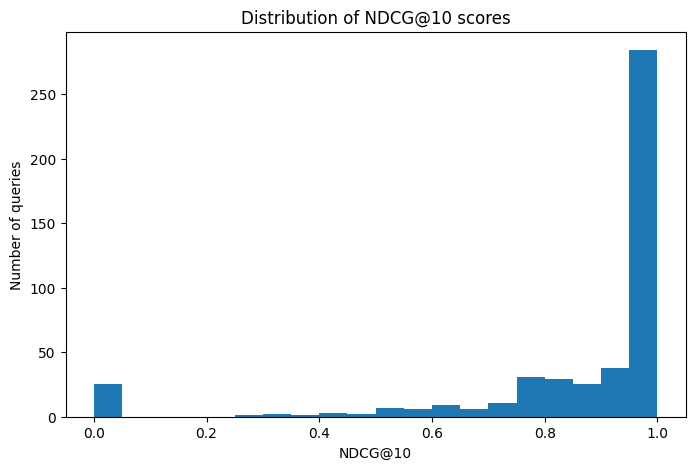

In [33]:
# Task 5c: Analyze the distribution

import matplotlib.pyplot as plt

# Task 5c: Visualize NDCG distribution

plt.figure(figsize=(8,5))
plt.hist(eval_results["ndcg"], bins=20)
plt.xlabel("NDCG@10")
plt.ylabel("Number of queries")
plt.title("Distribution of NDCG@10 scores")
plt.show()



The distribution is heavily skewed toward high NDCG values, with most queries scoring close to 1.0. This means that for the majority of searches, the BM25 system ranks highly relevant products near the top of the results. The tall spike near 1.0 shows that the search engine performs very well on most product-specific queries.

However, there is a small cluster of queries with very low or zero NDCG. These represent failure cases where BM25 cannot match the user’s intent. As seen earlier, many of these queries are abstract or conceptual (e.g., “living room ideas”) rather than specific product requests. This highlights a key limitation of lexical search: it works best for concrete keyword matching but struggles with intent-based or inspirational queries.

Overall, the histogram shows that BM25 is strong for exact product search but has weaknesses in semantic understanding.

---

## Task 6: Improve Search with Additional Fields

Our baseline only searches the `product_name` field. Let's improve by adding more fields!

### 6a. Index product_class field

The `product_class` field contains the category of the product (e.g., "Rugs", "Coffee Tables"). This is a powerful signal!

Create a search function that combines all three fields (name, description, class).

In [34]:
# Task 6a: Index product_class field


# Build index for product_class
class_docs = products["product_class"].fillna("").astype(str).tolist()
class_index, class_doc_lengths = build_index(class_docs, snowball_tokenize)

print("Class docs indexed:", len(class_docs))
print("Unique terms in class index:", len(class_index))
print("Avg class length:", np.mean(class_doc_lengths))

def bm25_three_field_search(query: str, k: int = 10) -> pd.DataFrame:
    name_scores = score_bm25(query, index, len(products), doc_lengths, snowball_tokenize)
    desc_scores = score_bm25(query, desc_index, len(products), desc_doc_lengths, snowball_tokenize)
    class_scores = score_bm25(query, class_index, len(products), class_doc_lengths, snowball_tokenize)

    combined_scores = name_scores + desc_scores + class_scores  # simple multi-field combine

    top_k_idx = np.argsort(-combined_scores)[:k]
    results = products.iloc[top_k_idx].copy()
    results["score"] = combined_scores[top_k_idx]
    results["rank"] = range(1, k + 1)
    return results

# Quick sanity test
display(bm25_three_field_search("coffee table", k=10)[
    ["rank", "product_id", "product_name", "product_class", "score"]
])


Class docs indexed: 42994
Unique terms in class index: 628
Avg class length: 2.2010513094850443


,rank,product_id,product_name,product_class,score
34496,1,34496,picacho coffee table,Coffee & Cocktail Tables,21.260129
29952,2,29952,metpally coffee table,Coffee & Cocktail Tables,20.946081
26857,3,26857,elmcrest coffee table,Coffee & Cocktail Tables,20.834425
38673,4,38673,abdulsamet coffee table,Coffee & Cocktail Tables,20.817171
16877,5,16877,mendivil coffee table,Coffee & Cocktail Tables,20.817171
31403,6,31403,hansmeier coffee table,Coffee & Cocktail Tables,20.765976
6344,7,6344,huling coffee table,Coffee & Cocktail Tables,20.720970
22677,8,22677,olive coffee table,Coffee & Cocktail Tables,20.711335
18381,9,18381,eraman coffee table,Coffee & Cocktail Tables,20.665374
7185,10,7185,norfolk coffee table,Coffee & Cocktail Tables,20.641140


### 6b. Evaluate three-field search

Now evaluate your three-field search on all queries to see how it compares to the baseline.

In [35]:
# Task 6b: Evaluate three-field search


eval_three = evaluate_search(
    search_func=lambda q: bm25_three_field_search(q, k=10),
    products_df=products,
    queries_df=queries,
    labels_df=labels,
    k=10,
    verbose=True
)

eval_three.head()


Evaluated 480 queries
Mean NDCG@10: 0.8791


,query_id,query,ndcg
0,0,salon chair,1.000000
1,1,smart coffee table,1.000000
2,2,dinosaur,1.000000
3,3,turquoise pillows,0.897263
4,4,chair and a half recliner,0.812595


### 6c. Compare to baseline

Analyze which queries improved and which degraded when using three-field search.

In [36]:
# Task 6c: Compare to baseline

comparison = eval_results.merge(
    eval_three,
    on=["query_id", "query"],
    suffixes=("_baseline", "_three")
)

comparison["delta"] = comparison["ndcg_three"] - comparison["ndcg_baseline"]

improved = comparison[comparison["delta"] > 0].sort_values("delta", ascending=False)
degraded = comparison[comparison["delta"] < 0].sort_values("delta")

print("Top improved queries:")
display(improved.head(10))

print("\nTop degraded queries:")
display(degraded.head(10))


Top improved queries:


,query_id,query,ndcg_baseline,ndcg_three,delta
29,29,bathroom vanity knobs,0.000000,1.000000,1.000000
340,345,oriental vanity,0.000000,0.997188,0.997188
280,284,family lamp,0.000000,0.901118,0.901118
33,33,non slip shower floor tile,0.000000,0.825637,0.825637
58,58,medium size chandelier,0.000000,0.716408,0.716408
145,145,liberty hardware francisco,0.315465,0.958871,0.643406
443,449,living room designs,0.000000,0.603985,0.603985
79,79,palram harmony greenhouses,0.000000,0.565206,0.565206
133,133,outdoor light fixtures,0.451818,1.000000,0.548182
469,476,hardwood beds,0.000000,0.528144,0.528144



Top degraded queries:


,query_id,query,ndcg_baseline,ndcg_three,delta
446,453,midcentury tv unit,1.000000,0.000000,-1.000000
45,45,70s inspired furniture,0.799669,0.000000,-0.799669
147,147,drum picture,0.965781,0.289065,-0.676716
403,409,teal chair,1.000000,0.471628,-0.528372
445,452,day bed indian,1.000000,0.500000,-0.500000
13,13,outdoor privacy wall,0.977015,0.500000,-0.477015
380,386,alter furniture,0.964180,0.489969,-0.474211
136,136,black fluffy stool,1.000000,0.537545,-0.462455
161,162,turquoise chair,1.000000,0.553974,-0.446026
20,20,foutains with brick look,0.997188,0.565206,-0.431981


---

## Task 7: Query Understanding with LLM

Sometimes users search for "star wars rug" when they really want a "rug with Star Wars theme". An LLM can help us understand what the user is actually looking for!

### 7a. Extract product type from query

Write a function using LiteLLM with structured outputs (Pydantic) to extract key information from a query.

In [1]:
# Task 7a: Query understanding with LiteLLM + Pydantic (FULL CODE)

import json
import re
import os
os.environ["LITELLM_LOG"] = "ERROR"
import litellm
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import Optional, List

# Load env vars (OPENAI_API_KEY / GEMINI_API_KEY etc.)
load_dotenv()

# (Optional) Control LiteLLM logging: "DEBUG", "INFO", "ERROR"
# os.environ["LITELLM_LOG"] = "ERROR"

class QueryAttributes(BaseModel):
    product_type: Optional[str] = Field(None, description="Main product type (e.g., rug, coffee table, chandelier)")
    theme: Optional[str] = Field(None, description="Theme/franchise/character/occasion (e.g., Star Wars, dinosaur)")
    material: Optional[str] = Field(None, description="Material (e.g., wood, metal, glass, leather)")
    color: Optional[str] = Field(None, description="Color(s) mentioned (e.g., blue, grey, turquoise)")
    style: Optional[str] = Field(None, description="Style intent (e.g., modern, farmhouse, vintage)")
    size: Optional[str] = Field(None, description="Size/dimensions if mentioned (e.g., 8x10, medium, small)")
    room: Optional[str] = Field(None, description="Room/placement intent (e.g., living room, teen room, bathroom)")
    brand: Optional[str] = Field(None, description="Brand/store mentioned (e.g., lowes, ikea)")
    constraints: List[str] = Field(default_factory=list, description="Other constraints (e.g., non-slip, washable)")
    rewritten_query: Optional[str] = Field(None, description="Clean explicit version of the query")

def _strip_code_fences(text: str) -> str:
    """Remove ```json ... ``` wrappers if present."""
    text = (text or "").strip()
    text = re.sub(r"^```(?:json)?\s*", "", text, flags=re.IGNORECASE)
    text = re.sub(r"\s*```$", "", text)
    return text.strip()

def extract_query_attributes(
    query: str,
    model: str = "gemini/gemini-2.5-flash",  # or "gpt-4o-mini"
    temperature: float = 0.0,
) -> QueryAttributes:
    """
    Extract product_type, theme, material, color, style, size, room, brand, constraints from a query.
    Returns a validated QueryAttributes object.
    """
    schema = QueryAttributes.model_json_schema()

    system_prompt = (
        "You are a query understanding component for e-commerce search.\n"
        "Return ONLY a valid JSON object matching the provided JSON Schema.\n"
        "Do NOT wrap in markdown code fences. Do NOT add explanations.\n"
        "Use null for unknown fields. 'constraints' must be a JSON list.\n"
    )

    user_prompt = f"""
Query: {query}

JSON Schema:
{json.dumps(schema, indent=2)}

Return ONLY the JSON object.
""".strip()

    resp = litellm.completion(
        model=model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        temperature=temperature,
        max_tokens=500,
    )

    raw = resp.choices[0].message.content or ""
    cleaned = _strip_code_fences(raw)

    # Attempt 1: parse full cleaned content
    try:
        data = json.loads(cleaned)
        obj = QueryAttributes.model_validate(data)
    except Exception:
        # Attempt 2: extract first {...} block if extra text exists
        start = cleaned.find("{")
        end = cleaned.rfind("}")
        if start != -1 and end != -1 and end > start:
            data = json.loads(cleaned[start : end + 1])
            obj = QueryAttributes.model_validate(data)
        else:
            raise ValueError(f"Could not parse model output as JSON.\nRaw output:\n{raw}")

    # Ensure rewritten_query is always set (helpful for later steps)
    if obj.rewritten_query is None:
        obj.rewritten_query = query

    return obj


In [4]:
rows = []

for q in test_queries:
    attrs = extract_query_attributes(q)
    
    print(f"\nQuery: {q}")
    print(attrs.model_dump())

    row = attrs.model_dump()
    row["original_query"] = q
    rows.append(row)

import pandas as pd
pd.DataFrame(rows)



Query: star wars rug
{'product_type': 'rug', 'theme': 'Star Wars', 'material': None, 'color': None, 'style': None, 'size': None, 'room': None, 'brand': None, 'constraints': [], 'rewritten_query': 'star wars rug'}

Query: wooden coffee table
{'product_type': 'coffee table', 'theme': None, 'material': 'wood', 'color': None, 'style': None, 'size': None, 'room': None, 'brand': None, 'constraints': [], 'rewritten_query': 'wooden coffee table'}

Query: blue leather sofa
{'product_type': 'sofa', 'theme': None, 'material': 'leather', 'color': 'blue', 'style': None, 'size': None, 'room': None, 'brand': None, 'constraints': [], 'rewritten_query': 'blue leather sofa'}

Query: modern metal bookshelf
{'product_type': 'bookshelf', 'theme': None, 'material': 'metal', 'color': None, 'style': 'modern', 'size': None, 'room': None, 'brand': None, 'constraints': [], 'rewritten_query': 'modern metal bookshelf'}


,product_type,theme,material,color,style,size,room,brand,constraints,rewritten_query,original_query
0,rug,Star Wars,None,None,None,None,None,None,[],star wars rug,star wars rug
1,coffee table,None,wood,None,None,None,None,None,[],wooden coffee table,wooden coffee table
2,sofa,None,leather,blue,None,None,None,None,[],blue leather sofa,blue leather sofa
3,bookshelf,None,metal,None,modern,None,None,None,[],modern metal bookshelf,modern metal bookshelf


### 7b. Create an LLM-enhanced search

Use the extracted product type to boost matching results. If the LLM identifies "rug" as the product type, boost products where `product_class` contains "rug".

In [27]:
import numpy as np
import pandas as pd
import string
from collections import Counter
import Stemmer

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str):
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs, tokenizer):
    index = {}
    doc_lengths = []

    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)

        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count

    return index, doc_lengths

def get_df(term, index):
    return len(index.get(term, {}))

def bm25_idf(df, num_docs):
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf, doc_len, avg_doc_len, k1=1.2, b=0.75):
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query, index, num_docs, doc_lengths, tokenizer):
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths)

    for token in query_tokens:
        df = get_df(token, index)
        if df == 0:
            continue

        idf = bm25_idf(df, num_docs)

        for doc_id, tf in index[token].items():
            tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len)
            scores[doc_id] += idf * tf_norm

    return scores


In [28]:
# name
docs = products["product_name"].fillna("").astype(str).tolist()
index, doc_lengths = build_index(docs, snowball_tokenize)

# description
desc_docs = products["product_description"].fillna("").astype(str).tolist()
desc_index, desc_doc_lengths = build_index(desc_docs, snowball_tokenize)

# class
class_docs = products["product_class"].fillna("").astype(str).tolist()
class_index, class_doc_lengths = build_index(class_docs, snowball_tokenize)


In [23]:
products["product_class"].fillna("").str.lower().str.contains("rug").mean()


np.float64(0.033051123412569196)

In [24]:
products.loc[
    products["product_class"].fillna("").str.lower().str.contains("rug"),
    "product_class"
].value_counts().head(20)


product_class
Area Rugs                           1316
Bath Rugs & Mats                      92
Rug Pads                               4
Licensed Products|Area Rugs            3
Bath Rugs & Mats|Shower Curtains       3
Shower Curtains|Bath Rugs & Mats       2
Area Rugs|Kitchen Mats                 1
Name: count, dtype: int64

In [25]:
def llm_enhanced_search(query: str, k: int = 10, boost: float = 50.0) -> pd.DataFrame:
    attrs = extract_query_attributes(query)
    ptype = (attrs.product_type or "").strip().lower()

    name_scores = score_bm25(query, index, len(products), doc_lengths, snowball_tokenize)
    desc_scores = score_bm25(query, desc_index, len(products), desc_doc_lengths, snowball_tokenize)
    class_scores = score_bm25(query, class_index, len(products), class_doc_lengths, snowball_tokenize)

    combined_scores = name_scores + desc_scores + class_scores

    if ptype:
        class_text = products["product_class"].fillna("").astype(str).str.lower()
        # special-case: rugs are often "Area Rugs", "Bath Rugs & Mats", etc.
        if ptype == "rug":
            mask = class_text.str.contains("rug", regex=False).to_numpy()
        else:
            mask = class_text.str.contains(ptype, regex=False).to_numpy()

        combined_scores = combined_scores + (boost * mask.astype(float))

    top_k_idx = np.argsort(-combined_scores)[:k]
    results = products.iloc[top_k_idx].copy()
    results["score"] = combined_scores[top_k_idx]
    results["rank"] = range(1, k + 1)
    results["extracted_product_type"] = attrs.product_type
    return results


In [26]:
display(llm_enhanced_search("star wars rug", k=10)[
    ["rank","product_id","product_name","product_class","score","extracted_product_type"]
])


,rank,product_id,product_name,product_class,score,extracted_product_type
4154,1,4154,truman medallion textured weave teal indoor/ou...,Area Rugs,67.466319,rug
20111,2,20111,truman bohemian medallion textured weave indoo...,Area Rugs,66.924308,rug
20110,3,20110,truman bohemian medallion textured weave indoo...,Area Rugs,66.924308,rug
37352,4,37352,bronte tufted wool black/gray rug,Area Rugs,66.783983,rug
37353,5,37353,bronte southwestern hand hooked wool beige are...,Area Rugs,66.379435,rug
18148,6,18148,aden awards night gold star runner black/gold,Area Rugs,65.528968,rug
4862,7,4862,glencoe area rug,Area Rugs,63.531715,rug
30307,8,30307,nidia gray rug,Area Rugs,63.398050,rug
30306,9,30306,anar gray rug,Area Rugs,63.398050,rug
16767,10,16767,amillian gray rug,Area Rugs,63.381095,rug


In [30]:
display(llm_enhanced_search("star wars rug", k=10))


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count,score,rank,extracted_product_type
4154,4154,truman medallion textured weave teal indoor/ou...,Area Rugs,Rugs / Area Rugs,"with its star-inspired medallion , this border...",overallwidth-sidetoside:63|location : indoor u...,258.0,5.0,180.0,67.466319,1,rug
20111,20111,truman bohemian medallion textured weave indoo...,Area Rugs,Rugs / Area Rugs,"with its star-inspired medallion , this border...",productcare : vacuum with no beater bar/rotati...,178.0,4.5,122.0,66.924308,2,rug
20110,20110,truman bohemian medallion textured weave indoo...,Area Rugs,Rugs / Area Rugs,"with its star-inspired medallion , this border...",technique : power loom|holidayoccasion : no ho...,221.0,5.0,158.0,66.924308,3,rug
37352,37352,bronte tufted wool black/gray rug,Area Rugs,Rugs / Area Rugs / 2' x 3' Area Rugs,southwestern motifs get a modern edge in the g...,overallwidth-sidetoside:60|technique : tufted|...,15.0,5.0,12.0,66.783983,4,rug
37353,37353,bronte southwestern hand hooked wool beige are...,Area Rugs,Rugs / Area Rugs / 2' x 3' Area Rugs,southwestern motifs get a modern edge in the g...,technique : looped/hooked|holidayoccasion : no...,39.0,5.0,26.0,66.379435,5,rug
18148,18148,aden awards night gold star runner black/gold,Area Rugs,Rugs / Area Rugs,use the gold star runner at the entrance to yo...,primarycolor : black/gold|gender : gender neut...,10.0,3.5,7.0,65.528968,6,rug
4862,4862,glencoe area rug,Area Rugs,Rugs / Area Rugs / 3' x 5' Area Rugs,this turkish rug is made of polypropylene . th...,supplierintendedandapproveduse : non residenti...,33.0,5.0,21.0,63.531715,7,rug
30307,30307,nidia gray rug,Area Rugs,Rugs / Area Rugs,best value area rug is artistically designed w...,backingmaterialdetails : jute|dssecondaryprodu...,47.0,4.5,37.0,63.398050,8,rug
30306,30306,anar gray rug,Area Rugs,Rugs / Area Rugs,best value area rug is artistically designed w...,location : indoor use only|material : polyeste...,4.0,5.0,3.0,63.398050,9,rug
16767,16767,amillian gray rug,Area Rugs,Rugs / Area Rugs,luxurious soft feel to the touch of your feet ...,technique : braided|countryoforigin-additional...,3.0,3.5,3.0,63.381095,10,rug


---
## Task 8: Submit via Pull Request

Now let's submit your work using the Git workflow from previous homeworks.
- [ ] Create a new branch called `homework-3`
- [ ] Commit you work and push it to the branch
- [ ] Create a PR with a nice description of your changes
- [ ] Merge the PR to your main branch
  
**The TA will verify your submission by checking the merged PR on your GitHub repo.**

**Also remember to submit your homework on Blackboard!**
